In [263]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from numba import jit
from scipy.integrate import solve_ivp

In [452]:
size = (6.5, 1)

# Kuramoto Model

We're using $\alpha = 1.457$, $\kappa = 4.0$ and 512 oscillators.

In [453]:
def g(y, κ):
    return κ*np.exp(-κ*np.abs(y))/2

In [454]:
def periodic_distance(x1, x2, length=1):
    return np.minimum(np.abs(x1 - x2), length - np.abs(x1 - x2))

In [267]:
xx, xy = np.meshgrid(np.linspace(0, 1, 512), np.linspace(0, 1, 512))
g_solved = g(periodic_distance(xx, xy), 4)

In [268]:
@jit
def ϕ̇(t, ϕ):
    ϕx, ϕy = np.meshgrid(ϕ, ϕ)
    return - np.sum(g_solved*np.sin(ϕy - ϕx + 1.457), axis=1)/512

In [269]:
ϕ0 = 2*np.pi*np.random.rand(512) - np.pi

In [270]:
%%time
kuramoto_sol = solve_ivp(ϕ̇, (0, 1000), ϕ0, t_eval=np.linspace(0, 1000, 100000), method="RK45")

CPU times: user 15.7 s, sys: 2.94 s, total: 18.6 s
Wall time: 11.9 s


In [271]:
def drop_phase(phase):
    return (phase + np.pi)%(2*np.pi) - np.pi

In [272]:
kuramoto_y = drop_phase(kuramoto_sol.y)

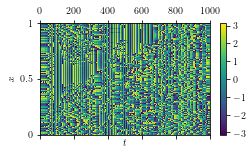

In [355]:
plt.matshow(kuramoto_y, aspect="auto", origin="lower")
plt.colorbar(kuramoto_overhead_im, cax=kuramoto_overhead_ax)
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.gca().set_xticklabels(["$-200$", "$0$", "$200$", "$400$", "$600$", "$800$", "$1000$"])
plt.yticks([0, 256, 512], ["$0$", "$0.5$", "$1$"])
plt.colorbar()

plt.gcf().set_size_inches(3.8, 2, forward=True)
plt.savefig("../figure/kuramoto_overhead", dpi=700, bbox_inches="tight")

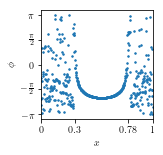

In [351]:
plt.plot(np.linspace(0, 1, 512), kuramoto_y[:, 12000], ".", markersize=3)
plt.xlim([0, 1])
plt.xticks([0, 0.3, 0.78, 1], ["$0$", "$0.3$", "$0.78$", "$1$"])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
plt.xlabel("$x$")
plt.ylabel(r"$\phi$")

plt.gcf().set_size_inches(2, 2, forward=True)

plt.savefig("../figure/kuramoto_snapshot", dpi=700, bbox_inches="tight")

# Abrams model

In [509]:
μ = 0.6
ν = 0.4
α = np.pi/2 - 0.1
n = 2048

In [510]:
k = ν*np.ones([n, n])
k[:n//2, :n//2] = μ
k[n//2:, n//2:] = μ

In [511]:
@jit
def θ̇(t, θ):
    θx, θy = np.meshgrid(θ, θ)
    return np.sum(k*np.sin(θy - θx - α), axis=1)/(n//2)

In [512]:
θ0 = 2*np.pi*np.random.random(n) - np.pi

In [515]:
θ0 = np.hstack([0.5 + 0.5*np.random.rand(n//2), 2*np.pi*np.random.rand(n//2) - np.pi])

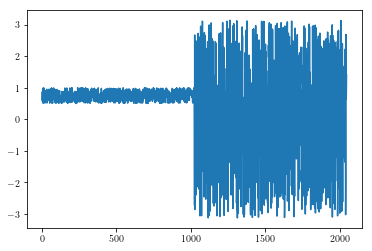

In [516]:
plt.plot(θ0)

In [517]:
%%time
abrams_sol = solve_ivp(θ̇, (0, 3000), θ0, max_step=0.01, method="RK45")

KeyboardInterrupt: 

In [518]:
abrams_y = drop_phase(abrams_sol.y)

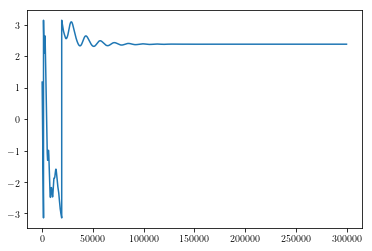

In [519]:
plt.plot(abrams_y[0])

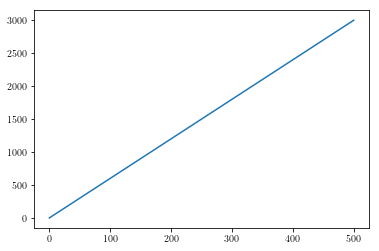

In [520]:
plt.plot(np.linspace(0, 500, abrams_sol.t.shape[0]), abrams_sol.t)

In [ ]:
plt.matshow(abrams_y, aspect="auto", origin="lower")
plt.colorbar()

In [ ]:
plt.plot(abrams_y[:, -1], "o")

# Wilson-Cowan Model
Note that the values given in Wang2012 are incorrect --- Rows 3(g),3(i) and 3(j),3(l) should be switched (at least).

In [52]:
cxx, cxy, cxz = 23, -15, -10
cyx, cyy, cyz = 35, 0, 0
czx, czy, czz = 10, 0, 0
p, q, r = 3, -5, -5
τx, τy, τz = 0.015, 0.013, 0.267

In [53]:
c = np.array([[cxx, cxy, cxz],
              [cyx, cyy, cyz],
              [czx, czy, czz]])
external = np.array([p, q, r])
τ = np.array([τx, τy, τz])

In [54]:
def wc_s(x):
    return 1/(1 + np.exp(4 - x))

In [55]:
def wc_dots(t, x):
    return (-x + wang_s(np.matmul(c, x) + external))/τ

In [56]:
wc0 = np.random.rand(3)

In [57]:
%%time
wc_sol = solve_ivp(wc_dots, (0, 1000), wc0, max_step=0.01, t_eval=np.linspace(500, 1000, 50000), method="RK45")

CPU times: user 38.6 s, sys: 402 ms, total: 39 s
Wall time: 41.7 s


In [58]:
wc_y = wc_sol.y

In [59]:
wc_y.shape

(3, 50000)

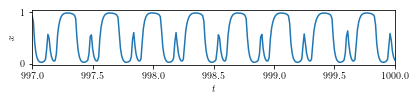

In [455]:
plt.plot(wc_sol.t, wc_y[0])
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.xlim([997, 1000])

fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig("../figure/wc", dpi=700, bbox_inches="tight")

In [ ]:
cxx, cxy, cxz = 23, -15, -10
cyx, cyy, cyz = 35, 0, 0
czx, czy, czz = 10, 0, 0
p, q, r = 3, -5, -5
τx, τy, τz = 0.015, 0.013, 0.267

In [101]:
def external(t):
    return np.array([3 + 0.02*t, -5, -5])

In [102]:
c = np.array([[cxx, cxy, cxz],
              [cyx, cyy, cyz],
              [czx, czy, czz]])
τ = np.array([τx, τy, τz])

In [103]:
def wc_dots_vary_params(t, x):
    return (-x + wang_s(np.matmul(c, x) + external(t)))/τ

In [104]:
%%time
wc_vary_p_sol = solve_ivp(wc_dots_vary_params, (0, 100), wc0, max_step=0.01, t_eval=np.linspace(25, 75, 5000), method="RK45")

CPU times: user 3.54 s, sys: 50.7 ms, total: 3.59 s
Wall time: 3.83 s


In [106]:
wc_vary_p_y = wc_vary_p_sol.y

In [110]:
wc_vary_p_sol.t.shape

(5000,)

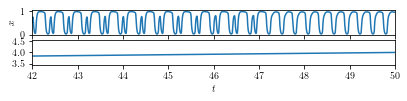

In [456]:
fig, [x_ax, p_ax] = plt.subplots(2, 1, sharex=True)
x_ax.plot(wc_vary_p_sol.t, wc_vary_p_y[0])
x_ax.set_ylabel("$x$")

p_ax.plot(wc_vary_p_sol.t, external(wc_vary_p_sol.t)[0])
p_ax.set_xlabel("$t$")
p_ax.set_xlim([42, 50])

fig.set_size_inches(*size, forward=True)
plt.savefig("../figure/wc", dpi=700, bbox_inches="tight")

# Epileptor

In [420]:
def epileptor_f1(x1, x2, z):
    return np.heaviside(x1, 1)*x1*(x2 - 0.6*(z - 4)**2) + np.heaviside(-x1, 0)*((x1**3) - 3*(x1**2))

In [421]:
def epileptor_f2(x1, x2):
    return np.heaviside(x2 + 0.25, 1)*6*(x2 + 0.25)

In [422]:
def epileptor(current, t, i1, i2, x0, τ0, τ2, γ):
    x1, y1, z, x2, y2, g = current
    dots = np.zeros_like(current)
    dots[0] = y1 - epileptor_f1(x1, x2, z) - z + i1
    dots[1] = 1 - 5*x1**2 - y1
    dots[2] = (4*(x1 - x0) - z)/τ0
    dots[3] = -y2 + x2 - x2**3 + i2 + 0.002*g - 0.3*(z - 3.5)
    dots[4] = (epileptor_f2(x1, x2) - y2)/τ2
    dots[5] = x1 - γ*g
    return np.hstack(dots)

In [423]:
x0 = -1.6
τ0 = 2857
τ2 = 10
i1 = 3.1
i2 = 0.01
γ = 0.01

In [424]:
ivs = np.random.normal(0, np.sqrt(0.025), 6)
ivs[1] -= 5
ivs[2] += 3

In [444]:
tmax = 2000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [445]:
params = (i1, i2, x0, τ0, τ2, γ)

In [446]:
%%time
epileptor_sol = solve_ivp(fun=lambda t_in, y_in: epileptor(y_in, t_in, *params),
                          t_span=(0, tmax), t_eval=t, y0=ivs.reshape(ivs.size), method="RK45")

CPU times: user 5.94 s, sys: 73.9 ms, total: 6.01 s
Wall time: 6.39 s


In [447]:
epileptor_y = epileptor_sol.y

In [448]:
epileptor_y.shape

(6, 200000)

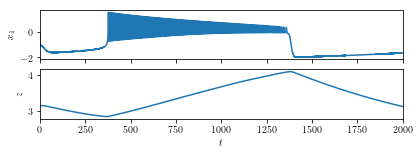

In [475]:
fig, [x1_ax, z_ax] = plt.subplots(2, sharex=True)
x1_ax.plot(epileptor_sol.t, epileptor_y[0])
z_ax.plot(epileptor_sol.t, epileptor_y[2])
z_ax.set_xlabel("$t$")
x1_ax.set_ylabel("$x_{1}$")
z_ax.set_ylabel("$z$")
z_ax.set_xlim([0, 2000])
fig = plt.gcf()
fig.set_size_inches(size[0], 2*size[1], forward=True)
plt.savefig("../figure/epileptor", dpi=700, bbox_inches="tight")